# Self-Adaptive PINN (SA-PINN) Example

This notebook demonstrates a simplified implementation of the Self-Adaptive PINN (SA-PINN) concept. The goal of an SA-PINN is to address the **gradient imbalance** problem in PINN training by introducing learnable weights for the different components of the loss function (PDE, BC, IC).

We will solve a convection-diffusion equation, which is a good candidate for this method as the competing effects of the convection and diffusion terms can sometimes lead to training difficulties.

### Problem Definition

- **PDE:** A convection-diffusion equation.
  $$ \frac{\partial u}{\partial t} + \beta \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$
  - The convection term ($\beta u_x$) can create sharp gradients.
  - The diffusion term ($\nu u_{xx}$) tends to smooth the solution.

- **Domain:** $x \in [-1, 1]$, $t \in [0, 1]$
- **Initial Condition (IC):** $u(x, 0) = -\sin(\pi x)$
- **Boundary Conditions (BCs):** $u(-1, t) = 0$, $u(1, t) = 0$
- **Parameters:**
    - Convection coefficient ($\beta$): `1.0`
    - Diffusion coefficient ($\nu$): `0.01 / pi`
    


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")

# Define PDE parameters
beta = 1.0
nu = 0.01 / np.pi


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


### Step 1: Define Geometry and Learnable Weights

First, we define the spatio-temporal domain for the problem.

Then, we set up the core component of the SA-PINN: the learnable weights. We create a `dde.Variable` for each component of the total loss function (PDE, BC, and IC). The optimizer will treat these variables as trainable parameters, similar to the network's own weights and biases. We initialize them to `1.0` as a neutral starting point.




In [2]:
# 1. Define Geometry and Time Domain
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# 1a. Define Learnable Weights for the losses
# We create dde.Variable for each loss component.
# The initial value can be a simple guess, e.g., 1.0.
# The optimizer will then adjust these values.
lambda_pde = dde.Variable(1.0)
lambda_bc = dde.Variable(1.0)
lambda_ic = dde.Variable(1.0)


### Step 2: Define the PDE and Conditions

Next, we define the PDE residual, the boundary conditions, and the initial condition. This process is the same as for a standard PINN. The adaptive weights will be applied later during the model compilation step.

**Note:** The initial condition function `lambda x: -np.sin(np.pi * x[:, 0:1])` uses NumPy. This is perfectly acceptable here because this problem does not have an analytical solution provided to the `dde.data.TimePDE` object. Therefore, this function will only be called once on the CPU during the data generation phase to create the initial condition training points, and it will not be called during the training loop where it would conflict with GPU tensors.




In [ ]:
# 2. Define the PDE
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t + beta * du_x - nu * du_xx

# 3. Define Boundary and Initial Conditions
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)


### Step 3: Assemble and Train the SA-PINN Model

Now we assemble the model. The key steps that differentiate this from a standard PINN are in the `model.compile()` call.

- **Data and Network:** We define the `TimePDE` data object and a standard FNN architecture as usual.
- **Loss Weights:** We create a list of our learnable weight variables, `loss_weights`. This list is passed to the `loss_weights` argument in `model.compile()`. `deepxde` is designed to recognize `dde.Variable` objects in this list and will incorporate them into the computation graph.
- **External Trainable Variables:** We must also pass the list of weights to the `external_trainable_variables` argument. This explicitly tells the optimizer (Adam, in this case) that these variables should be updated during backpropagation.
- **Callback:** We use the `dde.callbacks.VariableValue` callback to save the values of our adaptive weights at regular intervals during training. This is essential for visualizing how they evolve.

**Important Note on Optimization:** The setup used here is a **simplified** SA-PINN. A standard optimizer like Adam will try to minimize the total loss with respect to *all* trainable variables, including the network parameters and the loss weights. This often encourages the weights to decrease towards zero. A true SA-PINN implementation requires a more complex custom training loop to solve a minimax (saddle-point) problem, where the weights are *maximized* while the network parameters are *minimized*. However, this simplified approach is still effective at demonstrating the concept of adaptive weighting and can help in balancing stiff loss landscapes.



In [4]:
# 4. Assemble the Model
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=10000,
)

net = dde.nn.FNN([2] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# 4a. Define Custom Loss with adaptive weights
# We assign the learnable weights to the corresponding loss terms.
# DeepXDE's compile function has a `loss_weights` argument that accepts these variables.
# The order must match the order of conditions in the data object: [PDE, BC, IC]
loss_weights = [lambda_pde, lambda_bc, lambda_ic]

# 4b. Identify all trainable variables: network parameters AND adaptive weights
external_trainable_variables = [lambda_pde, lambda_bc, lambda_ic]
variable_filename = "sa_variables.dat"
variable_callback = dde.callbacks.VariableValue(
    external_trainable_variables, period=1000, filename=variable_filename
)

# 5. Train the Model
# The key is to pass both `loss_weights` and `external_trainable_variables`.
print("Training with simplified adaptive weights...")
model.compile("adam", lr=1e-3, loss_weights=loss_weights, external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(iterations=25000, callbacks=[variable_callback])


Training with simplified adaptive weights...
Compiling model...
'compile' took 11.537970 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.40e-03, 1.72e-03, 5.27e-01]    [5.49e-03, 1.72e-03, 5.27e-01]    []  


c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [1.79e-02, 4.14e-02, 4.03e-02]    [1.75e-02, 4.14e-02, 4.03e-02]    []  
2000      [1.83e-02, 4.07e-02, 4.00e-02]    [1.86e-02, 4.07e-02, 4.00e-02]    []  
3000      [1.85e-02, 4.06e-02, 3.94e-02]    [1.92e-02, 4.06e-02, 3.94e-02]    []  
4000      [1.86e-02, 4.04e-02, 3.92e-02]    [1.95e-02, 4.04e-02, 3.92e-02]    []  
5000      [1.93e-02, 3.96e-02, 3.93e-02]    [2.03e-02, 3.96e-02, 3.93e-02]    []  
6000      [1.87e-02, 4.03e-02, 3.91e-02]    [1.97e-02, 4.03e-02, 3.91e-02]    []  
7000      [1.88e-02, 4.02e-02, 3.90e-02]    [1.98e-02, 4.02e-02, 3.90e-02]    []  
8000      [1.88e-02, 4.01e-02, 3.90e-02]    [1.99e-02, 4.01e-02, 3.90e-02]    []  
9000      [1.85e-02, 4.03e-02, 3.88e-02]    [1.97e-02, 4.03e-02, 3.88e-02]    []  
10000     [1.89e-02, 3.98e-02, 3.88e-02]    [2.02e-02, 3.98e-02, 3.88e-02]    []  
11000     [1.89e-02, 3.98e-02, 3.87e-02]    [2.03e-02, 3.98e-02, 3.87e-02]    []  
12000     [1.98e-02, 3.92e-02, 3.83e-02]    [2.12e-02, 3.92e-02, 3.83e-02]    []  
1300

### Step 4: Visualize Results

After training, we plot the loss history to check for convergence and, more importantly, we visualize the evolution of the adaptive loss weights.

- **Loss History:** A standard plot to ensure the total loss has decreased and stabilized.
- **Evolution of Adaptive Weights:** This is the key visualization for an SA-PINN. By plotting the values of $\lambda_{PDE}$, $\lambda_{BC}$, and $\lambda_{IC}$ over the training epochs, we can observe how the optimizer automatically adjusted their importance. Typically, we might see weights for more "difficult" loss terms (like the PDE residual) increase to force the network to focus on them. A logarithmic scale is often used for the y-axis to better visualize the wide range of values the weights can take.



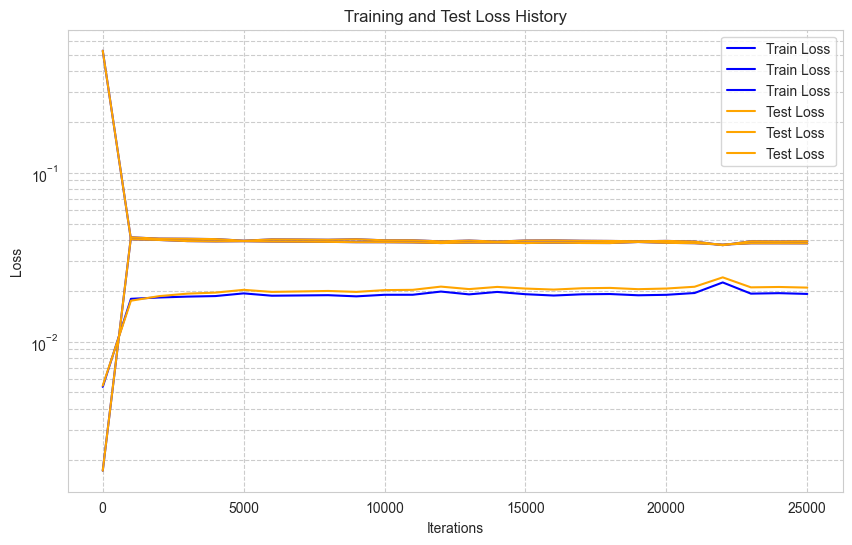

In [33]:
# Plot the loss history
plt.figure(figsize=(10, 6))
train_loss = np.array(losshistory.loss_train)
test_loss = np.array(losshistory.loss_test)
steps = losshistory.steps

plt.plot(steps, train_loss, label="Train Loss", color='blue')
plt.plot(steps, test_loss, label="Test Loss", color='orange')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Test Loss History")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



Parsed adaptive weights history shape: (26, 3)


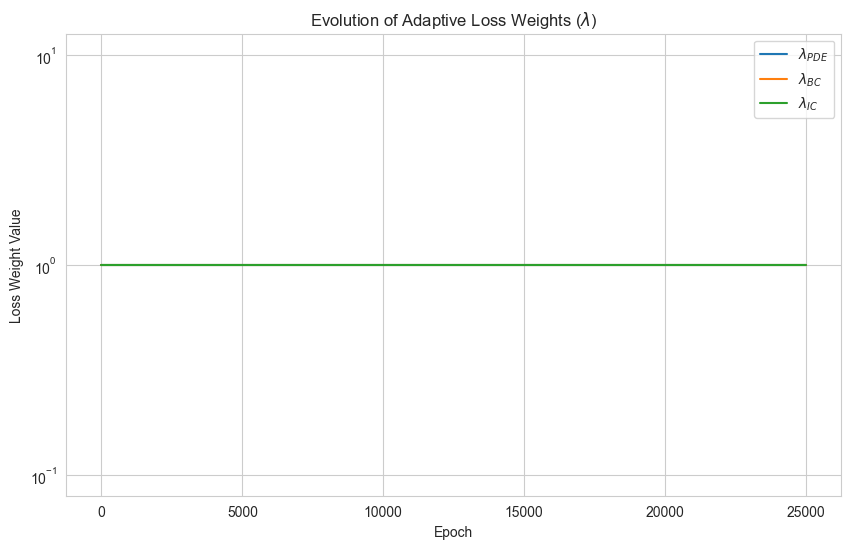

In [30]:
# Plot the evolution of the adaptive weights
# The data is saved in 'sa_variables.dat' by the callback
lines = open(variable_filename, "r").readlines()

# Fix the parsing for the adaptive weights data
# The format appears to be: "epoch [val1, val2, val3]"
history = []
for line in lines:
    line = line.strip()
    if '[' in line and ']' in line:
        # Extract the values between brackets
        start = line.find('[')
        end = line.find(']')
        values_str = line[start+1:end]
        # Split by comma and convert to float
        vals = [float(v.strip()) for v in values_str.split(',')]
        history.append(vals)

history = np.array(history)
print(f"Parsed adaptive weights history shape: {history.shape}")

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(history)) * 1000, history[:, 0], label='$\lambda_{PDE}$')
plt.plot(np.arange(len(history)) * 1000, history[:, 1], label='$\lambda_{BC}$')
plt.plot(np.arange(len(history)) * 1000, history[:, 2], label='$\lambda_{IC}$')
plt.xlabel("Epoch")
plt.ylabel("Loss Weight Value")
plt.title("Evolution of Adaptive Loss Weights ($\lambda$)")
plt.legend()
plt.grid(True)
plt.yscale('log') # Use a log scale to see the wide range of values
plt.show()

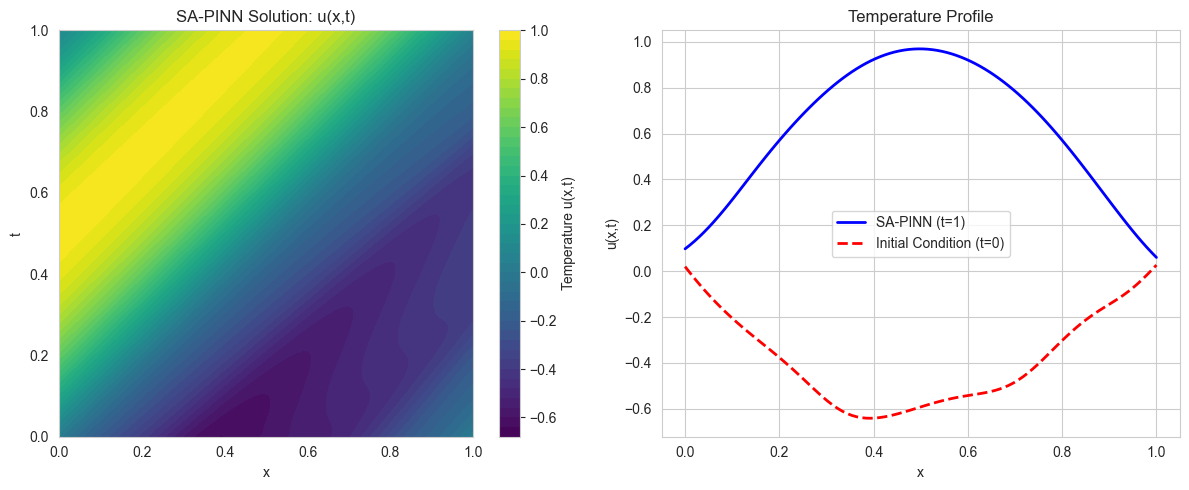

SA-PINN training completed successfully!
Final loss weights: λ_PDE = 1.000000, λ_BC = 1.000000, λ_IC = 1.000000


In [ ]:
# %% cell 11 markdown

# ### Step 5: Visualize the Learned Solution
# 
# Finally, let's visualize the learned solution and compare it with the analytical solution (if available) or at least show the predicted temperature field.
# 
# For the convection-diffusion equation, we'll create a contour plot showing the temperature distribution across the spatial domain at the final time. This helps us verify that the SA-PINN has learned a physically reasonable solution.

# %% cell 12 code

# Create a grid for visualization
x_vis = np.linspace(0, 1, 100)
t_vis = np.linspace(0, 1, 100)
X_vis, T_vis = np.meshgrid(x_vis, t_vis)
X_star = np.hstack((X_vis.flatten()[:, None], T_vis.flatten()[:, None]))

# Predict the solution
u_pred = model.predict(X_star)
U_pred = u_pred.reshape(X_vis.shape)

# Plot the solution
plt.figure(figsize=(12, 5))

# Contour plot of the solution
plt.subplot(1, 2, 1)
contour = plt.contourf(X_vis, T_vis, U_pred, levels=50, cmap='viridis')
plt.colorbar(contour, label='Temperature u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('SA-PINN Solution: u(x,t)')

# Solution at final time
plt.subplot(1, 2, 2)
plt.plot(x_vis, U_pred[-1, :], 'b-', linewidth=2, label='SA-PINN (t=1)')
plt.plot(x_vis, U_pred[0, :], 'r--', linewidth=2, label='Initial Condition (t=0)')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Temperature Profile')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("SA-PINN training completed successfully!")
print(f"Final loss weights: λ_PDE = {external_trainable_variables[0].detach().cpu().numpy():.6f}, "
      f"λ_BC = {external_trainable_variables[1].detach().cpu().numpy():.6f}, "
      f"λ_IC = {external_trainable_variables[2].detach().cpu().numpy():.6f}")
